In [3]:
import cv2
import numpy as np
import matplotlib.pyplot as plt
from pathlib import Path

In [4]:
base_path = Path("satlite_gap/satlite_gap")
reference_sources = [
    base_path / "Google_Map_Tiles(0).tif",
    base_path / "Google_Map_Tiles(23).tif",
    base_path / "Google_Map_Tiles(29).tif"
]
target_sets = [
    [
        base_path / "Bing_Map_Tiles(0).tif",
        base_path / "MapBox_Map_Tiles(0).tif",
        base_path / "Yandex_Map_Tiles(0).tif"
    ],
    [
        base_path / "Bing_Map_Tiles(23).tif",
        base_path / "MapBox_Map_Tiles(23).tif",
        base_path / "Yandex_Map_Tiles(23).tif"
    ],
    [
        base_path / "Bing_Map_Tiles(29).tif",
        base_path / "MapBox_Map_Tiles(29).tif",
        base_path / "Yandex_Map_Tiles(29).tif"
    ]
]

In [5]:
sift = cv2.SIFT_create()
bf = cv2.BFMatcher()


Processing Tile Set: (0)


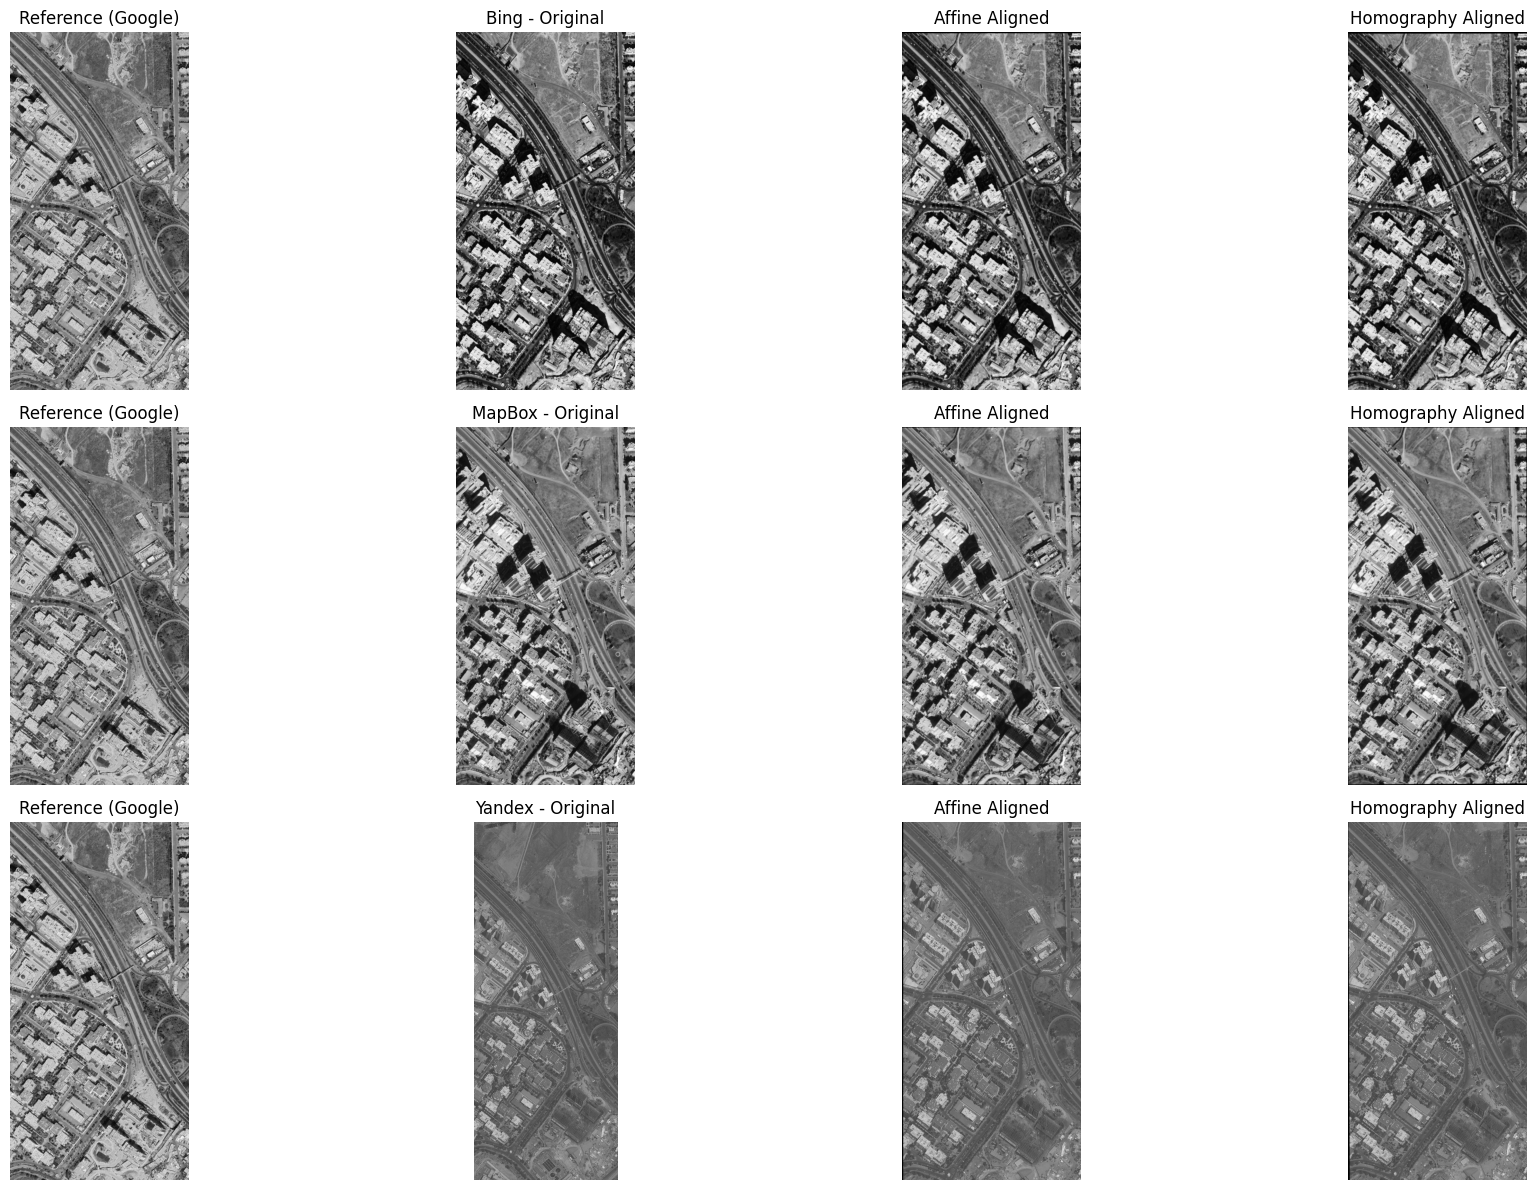


Processing Tile Set: (23)


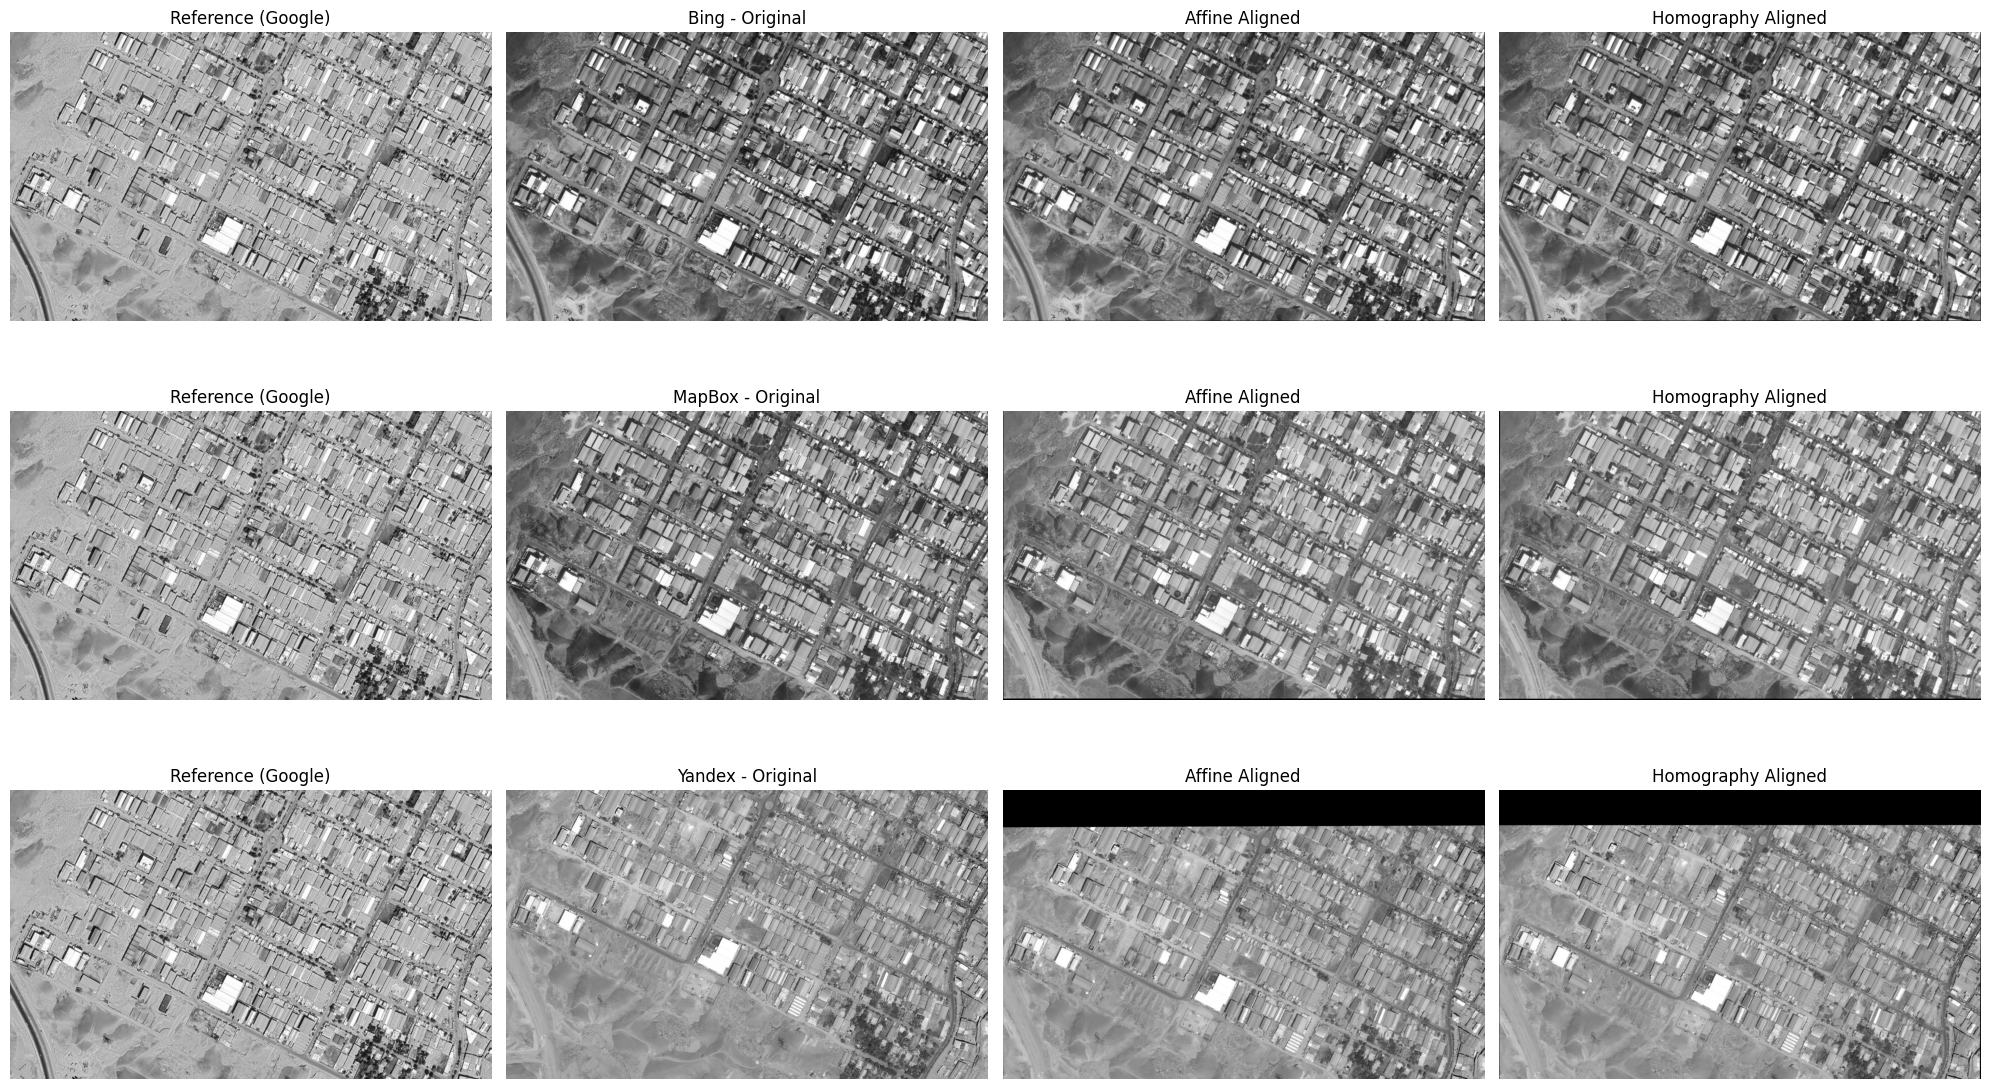


Processing Tile Set: (29)


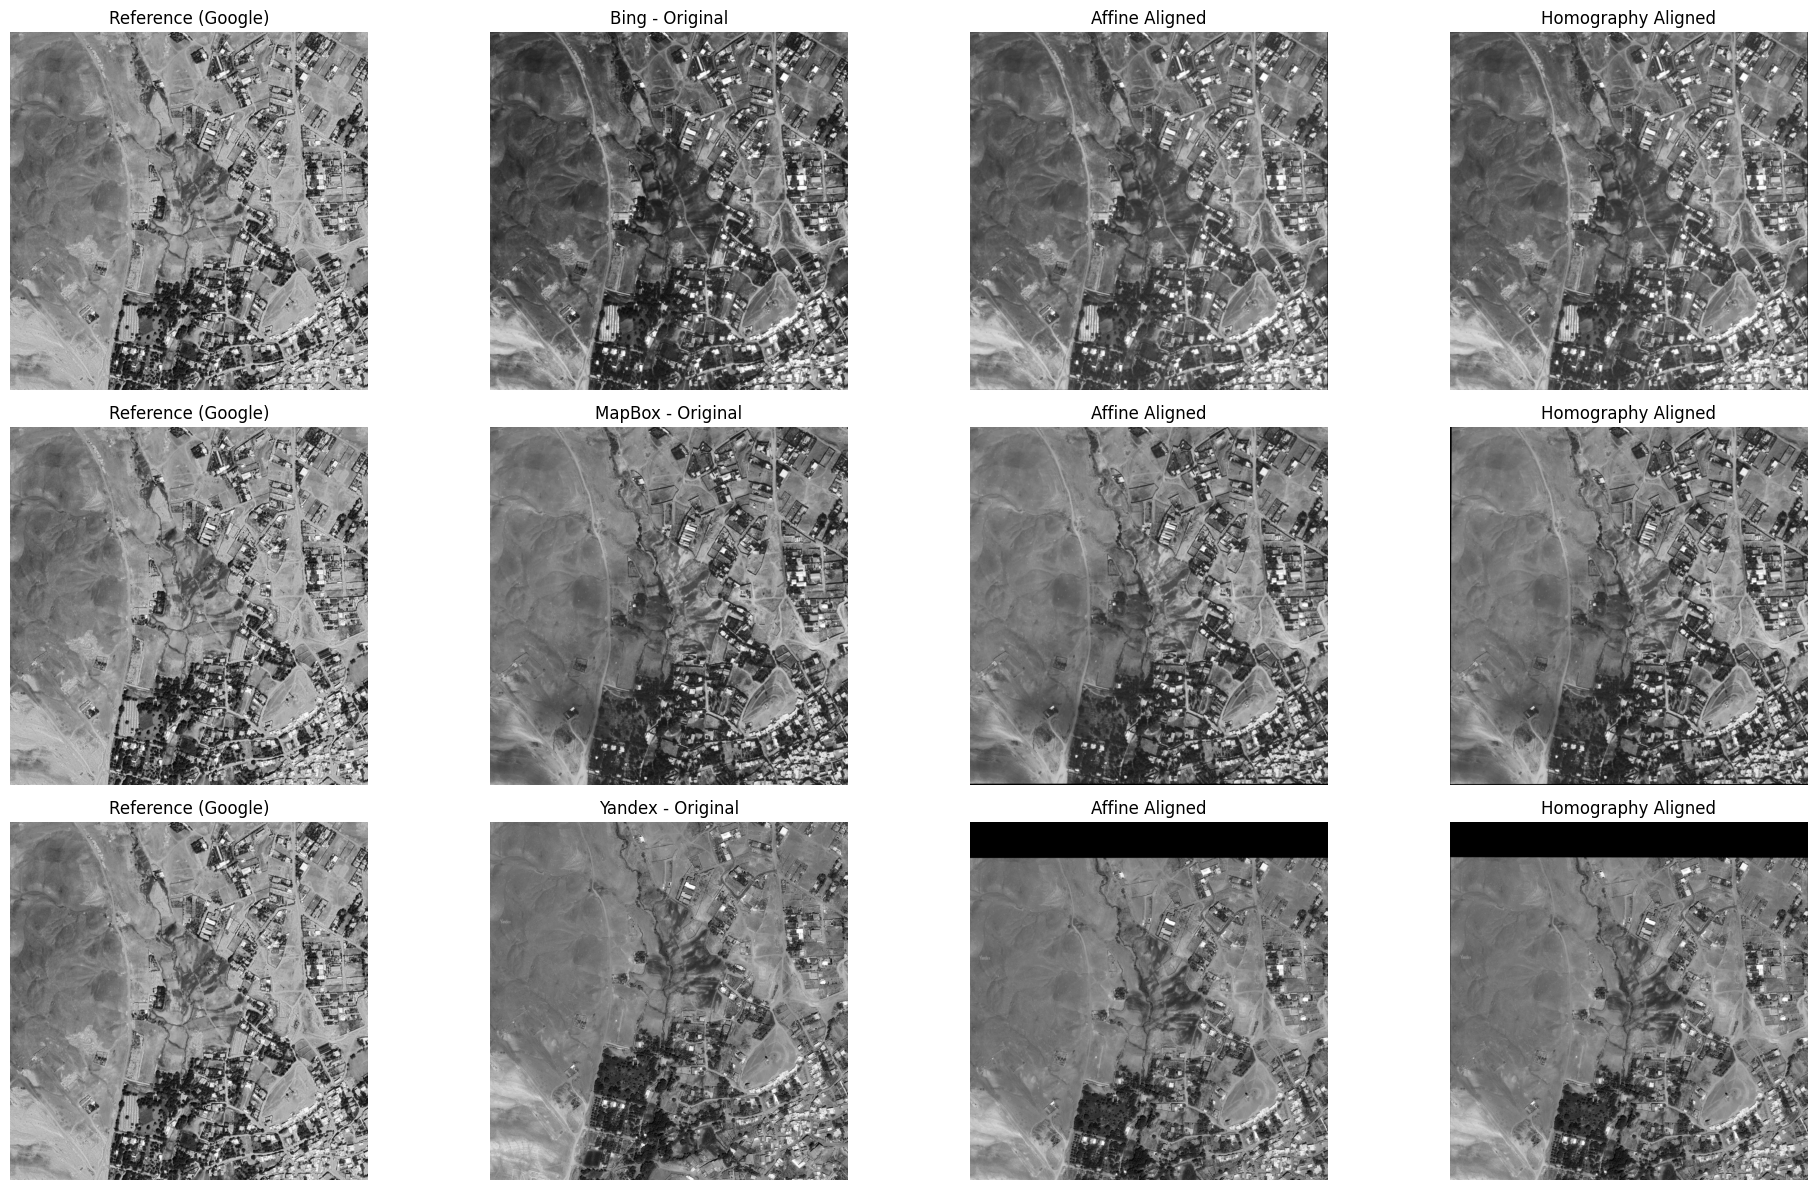

In [6]:
for set_idx, (ref_path, target_paths) in enumerate(zip(reference_sources, target_sets)):
    print(f"\nProcessing Tile Set: {['(0)', '(23)', '(29)'][set_idx]}")

    ref_img = cv2.imread(str(ref_path), cv2.IMREAD_GRAYSCALE)
    kp_ref, desc_ref = sift.detectAndCompute(ref_img, None)

    fig, axs = plt.subplots(len(target_paths), 4, figsize=(20, 12))
    source_names = ["Bing", "MapBox", "Yandex"]

    for i, target_path in enumerate(target_paths):
        target_img = cv2.imread(str(target_path), cv2.IMREAD_GRAYSCALE)
        kp_tgt, desc_tgt = sift.detectAndCompute(target_img, None)

        matches = bf.knnMatch(desc_ref, desc_tgt, k=2)
        good_matches = [m for m, n in matches if m.distance < 0.75 * n.distance]

        if len(good_matches) >= 10:
            src_pts = np.float32([kp_ref[m.queryIdx].pt for m in good_matches]).reshape(-1, 1, 2)
            dst_pts = np.float32([kp_tgt[m.trainIdx].pt for m in good_matches]).reshape(-1, 1, 2)

            # Affine
            M_affine, _ = cv2.estimateAffinePartial2D(dst_pts, src_pts)
            warp_affine = cv2.warpAffine(target_img, M_affine, (ref_img.shape[1], ref_img.shape[0]))

            # Homography
            M_homo, _ = cv2.findHomography(dst_pts, src_pts, cv2.RANSAC, 5.0)
            warp_homo = cv2.warpPerspective(target_img, M_homo, (ref_img.shape[1], ref_img.shape[0]))
        else:
            warp_affine = np.zeros_like(ref_img)
            warp_homo = np.zeros_like(ref_img)

        axs[i][0].imshow(ref_img, cmap='gray')
        axs[i][0].set_title("Reference (Google)")

        axs[i][1].imshow(target_img, cmap='gray')
        axs[i][1].set_title(f"{source_names[i]} - Original")

        axs[i][2].imshow(warp_affine, cmap='gray')
        axs[i][2].set_title("Affine Aligned")

        axs[i][3].imshow(warp_homo, cmap='gray')
        axs[i][3].set_title("Homography Aligned")

        for ax in axs[i]:
            ax.axis('off')

    plt.tight_layout()
    plt.show()